# Part 2: Dynamic Spin Structure Factor 

In [1]:
import a_mps, b_model, c_tebd
import numpy as np
import importlib
import matplotlib.pyplot as plt

In [7]:
importlib.reload(a_mps)
importlib.reload(b_model)
importlib.reload(c_tebd)

<module 'c_tebd' from 'c:\\Users\\work\\OneDrive - TUM\\Dokumente\\Studium\\QST MSc\\FoPra\\FoPra 32\\c_tebd.py'>

## Part a)

- Use the TEBD algorithm to write some code that performs a time evolution and calculates correlation functions of the form $C(t, j) = <\psi_0| e^{i H t} \sigma_j^y e^{-i H t} \sigma^y_{L/2}|\psi_0>$, where $|\psi_0>$ is the ground state of the transverse field Ising model. 
- During the time evolution, make sure to save the bipartite von-Neumann entanglement entropy $S(t) = −\sum_\alpha \Lambda_a^2(t) ln(\Lambda_\alpha^2(t))$, where $\Lambda_\alpha$ are the Schmidt values on the bond at the center of the time evolved state $|\psi(t)> = $e^{−iHt}\sigma^y_{L/2} |\psi_0>$.

In [3]:
sigma_z = np.array([[1, 0], [0, -1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])

In [24]:
def calc_ground_state(L, J, g, h, dt):
    E_0, psi_0, model = c_tebd.example_TEBD_gs_finite(L, J, g, h) # get the ground state and ground state energy
    U_bonds_0 = c_tebd.calc_U_bonds(model, dt)
    return E_0, psi_0, model, U_bonds_0

In [28]:
def calc_time_evolution(t, dt, psi_0, U_bonds_0, L = 30, J = 1, g = 1, h = 1):
    """Calculate e^-iHt sigma^y_(L/2)|psi_0>"""
    psi_t = psi_0.copy()
    psi_t_y = np.tensordot(sigma_y, psi_t.Bs[int(L//2)], [1, 1]) # i [i*], vL [i] vR
    psi_t.Bs[L//2] = psi_t_y.transpose([1, 0, 2]) # vL i vR
    entropies = [psi_t.entanglement_entropy()]
    psi_ts = [psi_t.copy()]
    for i in range(int(t//dt)):
        c_tebd.run_TEBD(psi = psi_t, U_bonds = U_bonds_0, N_steps = 1, chi_max = 100, eps = 10**(-6))
        entropies.append(psi_t.entanglement_entropy())
        psi_ts.append(psi_t.copy())
    return psi_ts, entropies

In [37]:
E_0, psi_0, model, U_bonds_0 = calc_ground_state(L = 20, J = 1, g = 0.5, h = 0, dt = 0.1)

finite TEBD, (imaginary time evolution)
L=20, J=1.0, g=0.50, h=0
dt = 0.10000: E = -20.3971033140100
dt = 0.01000: E = -20.3999098470175


In [32]:
psi_ts, entropies = calc_time_evolution(10, 0.01, psi_0, U_bonds_0, L = 20, J = 1, g = 0.5, h = 0)

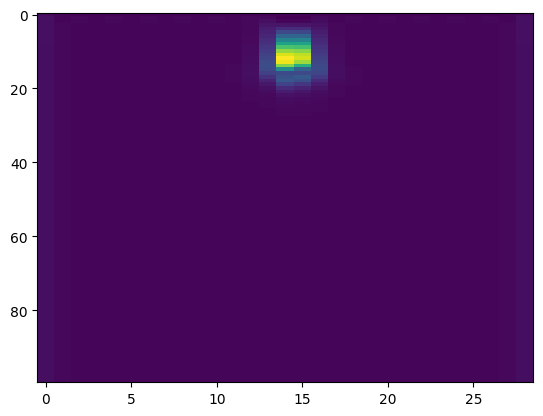

In [35]:
entropies = np.array(entropies)
plt.imshow(entropies, aspect = 'auto')
plt.show()

In [29]:
def calc_all_contractions_from_right(psi_1, psi_2, L):
    contractions_from_right = [np.tensordot(psi_1.Bs[L-1], np.conjugate(psi_2.Bs[L-1]), [[1,2], [1,2]])] # vL [i] [vR], vL* [i*] [vR*]
    for j in range(1, L-2):
        right_side = np.tensordot(psi_1.Bs[L-j-1], contractions_from_right[j-1], [2, 0]) # vL i [vR], [vL] vL*
        contractions_from_right.append(np.tensordot(np.conjugate(psi_2.Bs[L-j-1]), right_side, [[1,2], [1,2]])) # vL* [i*] [vR*], vL [i] [vL*]
    return contractions_from_right

In [ ]:
def calc_all_contractions_from_left_op(psi_1, psi_2, L, op):
    contractions_from_left = [np.tensordot(psi_1.Ss[0], np.conjugate(psi_2.Ss[0]), [0,0])] # [vL] vR, [vL*] vR*
    contractions_from_left_with_op = []
    for j in range(L):
        left_side = np.tensordot(contractions_from_left[j], psi_1.Bs[j], [0,0]) # [vR] vR*, [vL] i vR
        contractions_from_left.append(np.tensordot(left_side, np.conjugate(psi_2.Bs[j]))) # vR* i vR, vL i vR

In [14]:
def dssf_corr(t, dt, L = 30, J = 1, g = 1, h = 1):
    """Calculate correlation functions of the form <psi_0|e^iHt sigma^y_j e^-iHt sigma^y_(L/2)|psi_0> for all j"""
    E_0, psi_0, model, U_bonds_0 = calc_ground_state(L, J, g, h, dt) # get ground state
    psi_ts, entropies = calc_time_evolution(t, dt, psi_0, U_bonds_0, L, J, g, h)
    C = []
    for psi_t in psi_ts:
        c_list = []
        contractions_from_right = calc_all_contractions_from_right(psi_0, psi_t, L)
        left_side = 
        for j in range(L):
            left_side = 
            
    
    
    
    
    
    psi_t = np.exp(1j * E_0 * t) * psi_t